# Data Exploration

In [1]:
from datetime import date, datetime, timedelta, time
import pandas as pd
import numpy as np
import holidays
import math
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

## Add weather data

* keep in mind that weather might not be available for future predictions depending on how far away the predicted date is from the present
* including weather data here is merely to find out if there is an impact on the number of trips

In [7]:
df = pd.read_csv("../taxi_data/dropoffs.csv", index_col=[0])
df['dt'] = df[['year', 'month', 'day', 'hour']].apply(lambda s : datetime(*s),axis = 1)
usHolidays = holidays.UnitedStates()
# add dummy for if a day is an US holiday
df["holiday"] = df["dt"].apply(lambda x: x in usHolidays).astype(int)

In [8]:
w = pd.read_csv("../taxi_data/weather_prepared.csv", parse_dates=["dt"])
for i in w.columns[1:]:
    df = pd.merge(df, w[["dt", i]], on="dt", how="left")
#df = df.drop("dt", axis=1)
#df.to_csv("taxi_rides_w_weather.csv")

In [9]:
df.head()

,rides,location,year,month,day,hour,wday,holiday,dt,temp,...,temp_min,temp_max,humidity,wind_speed,rain_1h,rain_3h,snow_1h,snow_3h,weather_main,weather_description
0,1,2,2018,1,8,13,0,0,2018-01-08 13:00:00,-3.04,...,-3.40,-2.37,60.0,3.92,0.0,0.0,0.0,0.0,Clouds,overcast clouds
1,1,2,2018,1,14,14,6,0,2018-01-14 14:00:00,-4.42,...,-5.40,-3.30,48.0,3.83,0.0,0.0,0.0,0.0,Clear,sky is clear
2,1,2,2018,1,16,8,1,0,2018-01-16 08:00:00,-2.59,...,-4.01,-1.20,85.0,1.28,0.0,0.0,0.0,0.0,Clouds,overcast clouds
3,1,2,2018,1,19,19,4,0,2018-01-19 19:00:00,2.44,...,0.60,3.40,65.0,2.93,0.0,0.0,0.0,0.0,Clouds,few clouds
4,100,4,2018,1,1,0,0,1,2018-01-01 00:00:00,-12.47,...,-13.00,-10.98,65.0,3.96,0.0,0.0,0.0,0.0,Clear,sky is clear


## Add more calendar features

* adding sin and cos variation of calendar data might be helpful since there is a smoother transition between values (e.g. December (12) and January (1) are likely to behave similarly but have very different values when just using "12" and "1")

In [10]:
df["wday"] = df["dt"].apply(lambda x: x.weekday())

In [11]:
df["hour_of_year"] = df["dt"].apply(lambda x: (x-datetime(x.year,1,1)).days*24 + (x-datetime(x.year,1,1)).seconds // 3600)
df["hour_of_week"] = df.wday*24 + df.hour+1

In [12]:
#df["hour_of_week_cos"] = df["hour_of_week"].apply(lambda x: math.cos(x/168 * 2 * math.pi))
#df["hour_of_week_sin"] = df["hour_of_week"].apply(lambda x: math.sin(x/168 * 2 * math.pi))
#df["month_cos"] = df["month"].apply(lambda x: math.cos(x/12 * 2 * math.pi))
#df["month_sin"] = df["month"].apply(lambda x: math.sin(x/12 * 2 * math.pi))
#df["day_cos"] = df["day"].apply(lambda x: math.cos(x/31 * 2 * math.pi))
#df["day_sin"] = df["day"].apply(lambda x: math.sin(x/31 * 2 * math.pi))
#df["hour_cos"] = df["hour"].apply(lambda x: math.cos(x/24 * 2 * math.pi))
#df["hour_sin"] = df["hour"].apply(lambda x: math.sin(x/24 * 2 * math.pi))
#df["wday_cos"] = df["wday"].apply(lambda x: math.cos(x/7 * 2 * math.pi))
#df["wday_sin"] = df["wday"].apply(lambda x: math.sin(x/7 * 2 * math.pi))

In [19]:
df = df.drop("dt", axis=1)

## Feature importance with XGBoost

In [20]:
cat_features = list(df.columns[df.dtypes==object])
cat_features

[]

In [21]:
def get_feature_importance(data, no_of_features, cats=cat_features):
    # replace cat NaNs with 'missing'
    data[cat_features] = data[cat_features].fillna('missing')
    # turn cat features into numbers
    for col in data[cat_features]:
        data[col] = pd.factorize(data[col])[0]
    # fit XGB classifier to train data
    model = XGBRegressor()
    X = data.drop(columns=['rides'])
    y = data.rides
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    print("tts complete")
    #min_max_scaler = preprocessing.MinMaxScaler()
    #X_train = min_max_scaler.fit_transform(X_train)
    print(len(X_train))
    model.fit(X_train, y_train)
    print("fit complete")
    # zip column names with their respective feature importances
    fi = list(zip(list(X_train), model.feature_importances_))
    # sort by feature importance
    fi.sort(key=lambda x: x[1])
    # take x best features
    feature_list = list(zip(*fi[-no_of_features:]))
    # create plot
    plt.figure(figsize=(12, 5))
    plt.grid(b=None)
    plt.title('Feature Importance')
    plt.barh(range(len(feature_list[1])), feature_list[1])
    my_yticks = feature_list[0]
    plt.yticks(list(range(len(my_yticks))), my_yticks)
    plt.xlabel('Feature Score')
    plt.show()
    return my_yticks

tts complete
2268581


/Users/johannespastorek/opt/anaconda3/envs/nf/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:18:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
fit complete


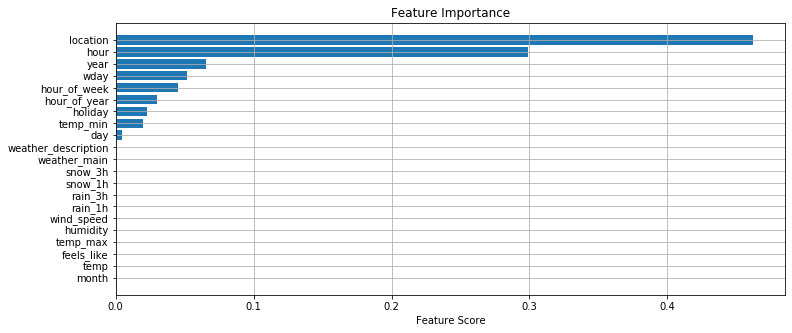

In [22]:
features = get_feature_importance(df, len(df.columns))

In [23]:
df1 = df[["rides", "location", "year", "month", "day", "hour", "wday", "holiday"]]

In [24]:
# df1.to_csv("../taxi_data/dropoffs.csv")